Changes to normflows (see https://github.com/nVentis/normalizing-flows)
- float precision check for discriminant: https://github.com/bayesiains/nflows/pull/71
- init_identity from: https://github.com/VincentStimper/normalizing-flows/blob/848277e2fdd306c16b48dc6814e2d7f8ddaeb2c8/normflows/flows/neural_spline/wrapper.py#L203
- added HypercubeUniform distribution with adjustable boundaries per dimension

In [1]:
import torch
from torchsummary import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.utils import module_reload
import pandas as pd

# NF example

In [2]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import normflows as nf
from normflows.distributions import BaseDistribution
from typing import Optional, Callable
import numpy as np
import pandas as pd
import torch

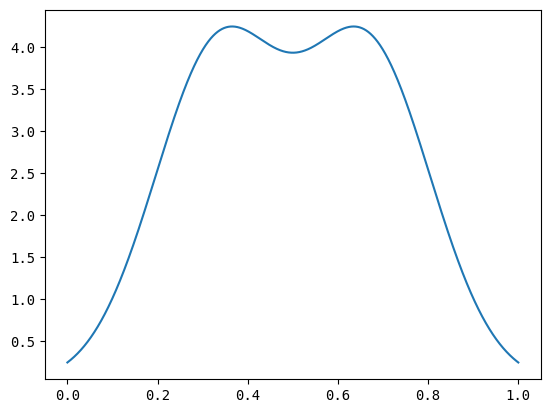

In [3]:
from analysis.mc.benchmarks import camel
n_samples = 10000
x = np.linspace(0, 1, n_samples)
oth = 0.5*np.ones(n_samples)

y = camel(np.array([x, oth, oth, oth]).T)
plt.plot(x, y)

In [4]:
def train_backward(nfm, func, n_samples:int=64000, n_epochs:int=10, lr:float=5e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    q = nfm.q0.log_prob_val.exp().detach()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(q*prob)) * results**2).sum()
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        else:
            print('Skipping epoch')
            
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [5]:
def func(args):
    lib = torch if isinstance(args, torch.Tensor) else np
    return lib.exp(-5*lib.sqrt(args.T[0]**2 + args.T[1]**2 +args.T[2]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)
    
    # old center: new_width/2
    # new center: (max+min)/2

Using device cuda
Model with 25992 parameters
Using inferred bounds 3.968681889245906e-06 to 0.9999979687293967


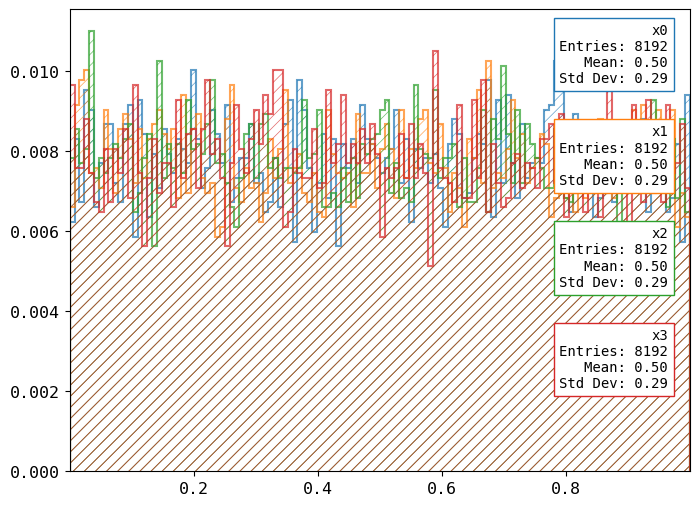

In [61]:
module_reload('analysis')
#torch.cuda.is_available = lambda : False
#torch.set_default_device('cpu')
torch.set_default_dtype(torch.float64)

from analysis.nis.transforms import ScaleShift
from analysis.mc.benchmarks import camel, gaussian
from analysis.nis.analyze import plot_proposal, plot_integrand, get_result
from analysis.nis.divergences import kl_div, chi2_div, exp_div, var_loss
from analysis.mc import NeuralImportanceSamplingIntegrator

ndims = 4
boundaries = [ [0]*ndims, [1]*ndims ]
uniform = HyperUniform(low=boundaries[0], high=boundaries[1], dtype=torch.float64)

nis = NeuralImportanceSamplingIntegrator(integrand=camel, boundaries=boundaries, lr=1e-4, hidden_channels=32,
                                         num_bins=16, hidden_layers=5, shift_scale=False, debug=False ) #device=torch.device('cpu'))
nis.print_model_summary()

#summary(nis.nfm, (nis.sample(4)[0]), depth=5)
plot_proposal(nis.nfm, n_samples=8192)


In [62]:
#plot_proposal(nis.nfm, n_samples=8192)
#plot_proposal(nis.q0, n_samples=8192)

print(f'NF @ Identity : {get_result(nis.nfm, camel, n_samples=32000)}')
print(f'Uniform dist  : {get_result(uniform, camel, n_samples=32000)}')

# samples, log_p = nfm.sample(1000)
# results = func(samples).detach().cpu().numpy()

# plot_integrand(nfm, func, n_samples=4096)

NF @ Identity : (0.96276592076427, 6.879074919543191)
Uniform dist  : (0.9873186840798629, 7.213977024044308)


  0%|          | 0/500 [00:00<?, ?it/s]

true 4998.369
28.084782278327143 380.8011957972759
Using inferred bounds 3.520627549457876e-06 to 0.9999959163156319
true 5005.545
28.25335522919318 387.1871289289074
true 5019.117
29.40965294747247 363.8029386488268
true 5020.583
23.674516822632615 381.38731516774277
true 5035.616
30.825604605459745 467.2476777128934
true 5045.663
27.57443947941927 400.74649783779347
true 5047.283
31.4697164690442 377.6271105166296
true 5066.413
29.48670964758211 438.13040302771094
true 5067.041
25.757783685199392 336.6118355847328
true 5082.180
28.021585063056655 420.579515428822
true 5087.712
31.161751821024797 372.17564420441397
true 5082.949
29.775541238329993 328.8480491472587
true 5102.576
30.044418037158973 342.91077391358374
true 5102.024
32.41116754975081 395.92476978757173
true 5122.412
27.984935881850102 399.8384623115334
true 5142.913
25.638960861938035 373.7355016158532
true 5139.132
30.289153832358 398.77601285924595
true 5153.878
30.599344364999187 415.8398830747885
true 5159.072
26.332

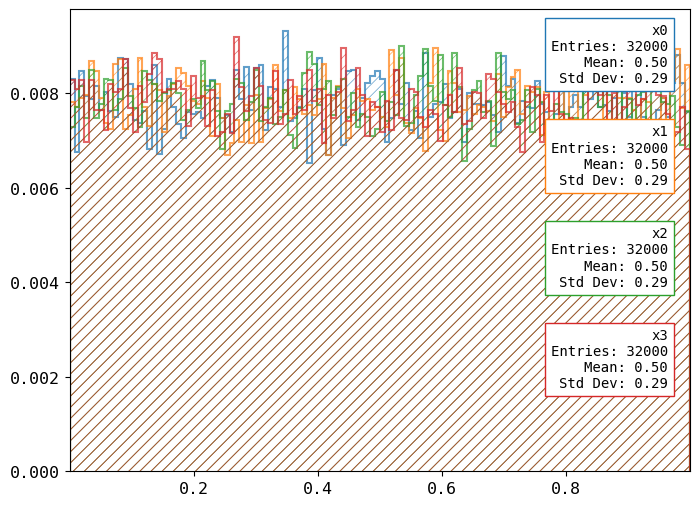

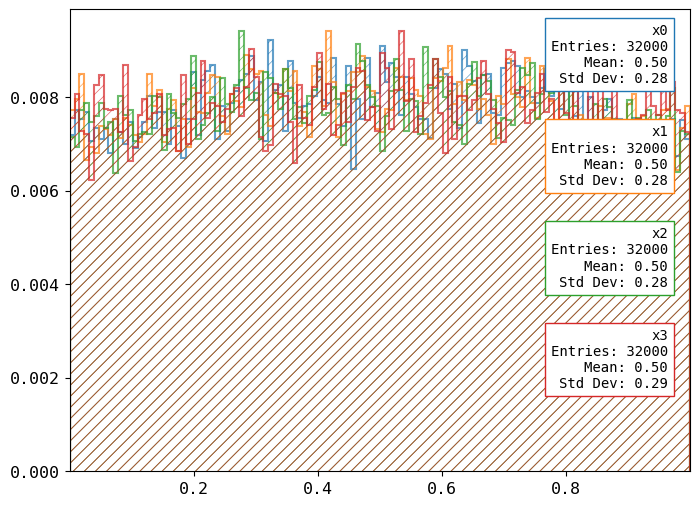

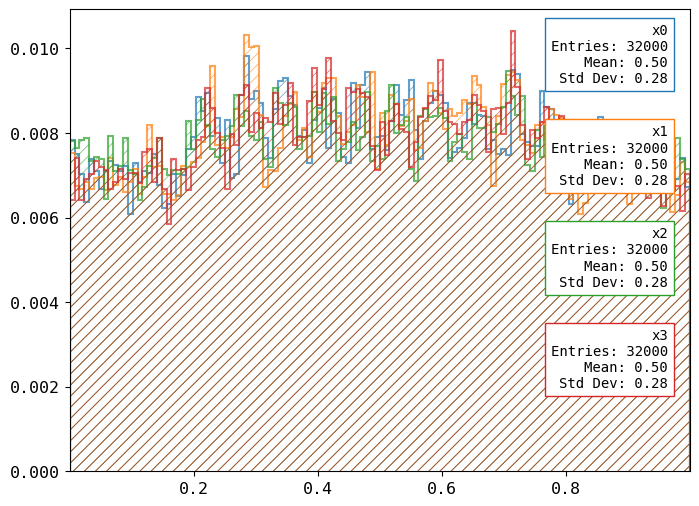

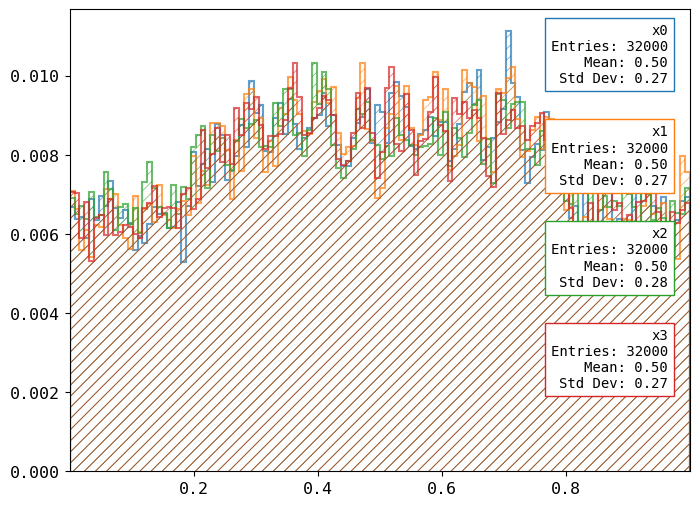

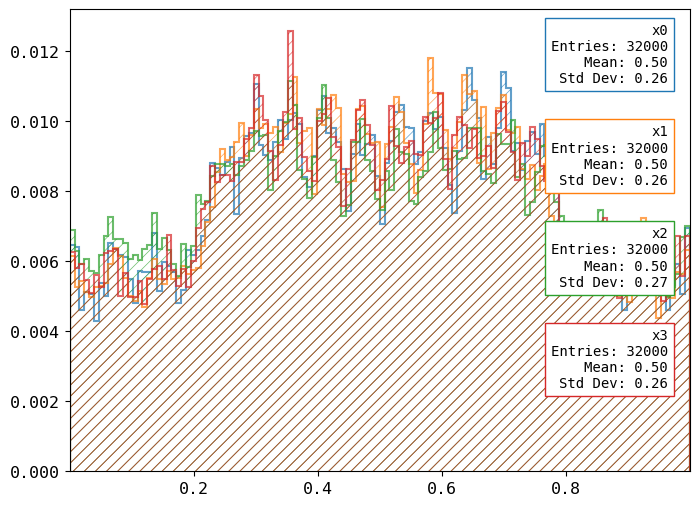

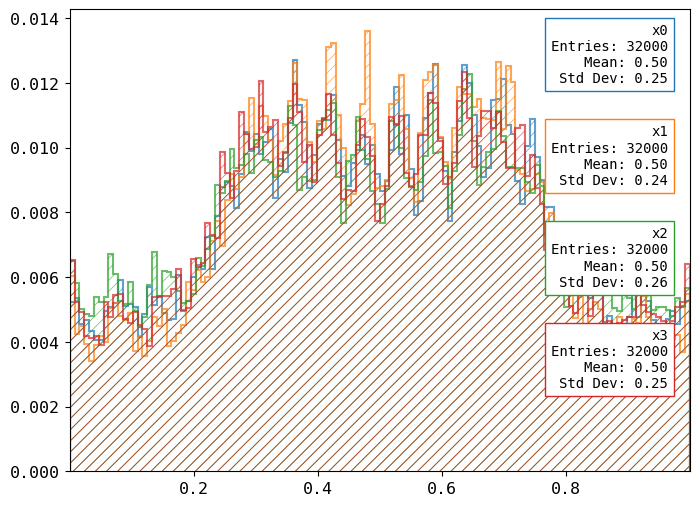

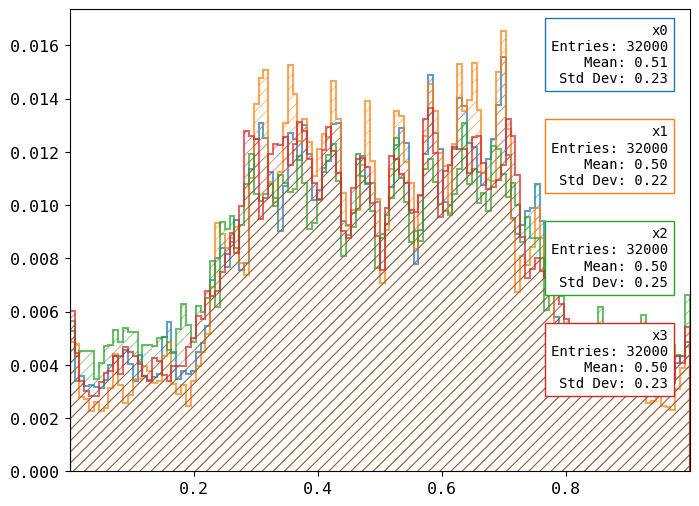

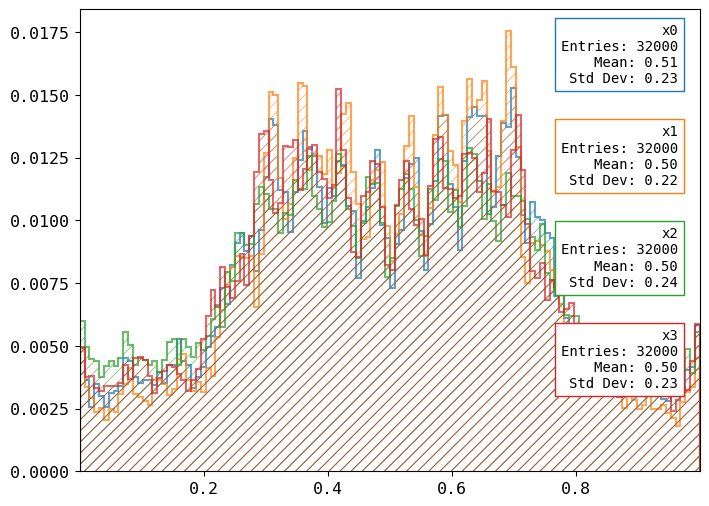

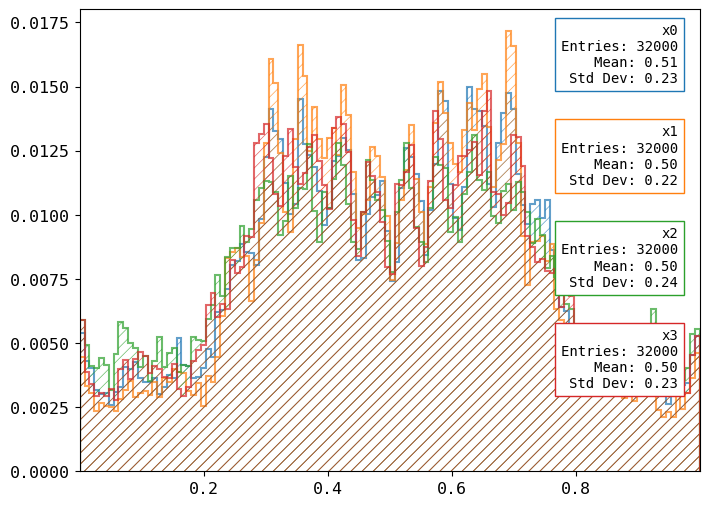

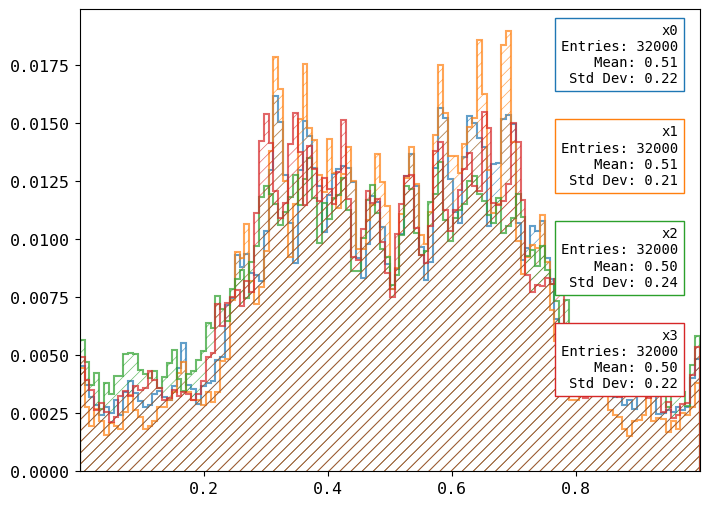

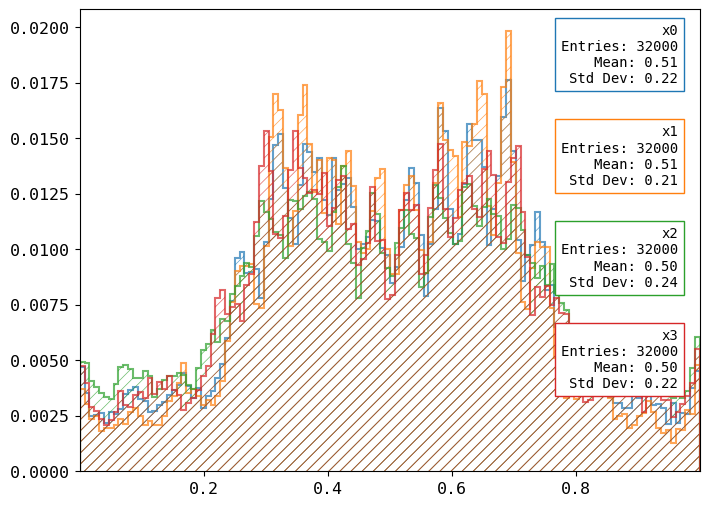

In [63]:
def report(nis):
    if nis.epoch_abs % 50 == 0:
        with torch.no_grad():
            plot_proposal(nis.nfm, n_samples=32000)

nis.adapt(n_epochs_max=500, loss_func=exp_div, n_samples=5000, n_max_fail=20, test_callback=report)
nis.empty_cache()

plot_proposal(nis.nfm, n_samples=32000)

In [46]:
# nis.save('/root/DevRepositories/MEM_HEP/camel4.pt')

Estimate: (0.9613251028760853, 0.0017717315796714481)


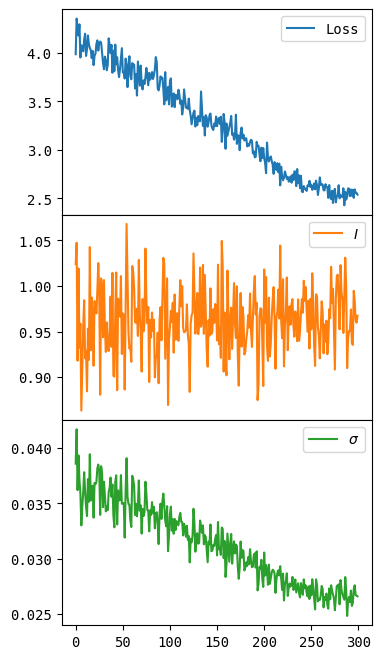

In [53]:
from analysis.plot_matplotlib import get_colorpalette

palette = get_colorpalette()
fig, ax = plt.subplots(3, 1, figsize=(4,8), gridspec_kw={'hspace': 0, 'wspace': 0})
ax[0].plot(np.arange(nis.epoch_abs), nis.statistics['train_losses'], label=r'Loss', color=palette[0])
ax[0].set_xlabel(r'Epoch')

ax[1].plot(np.arange(nis.epoch_abs), nis.statistics['train_results'], label=r'$I$', color=palette[1])
ax[2].plot(np.arange(nis.epoch_abs), nis.statistics['train_sigmas'], label=r'$\sigma$', color=palette[2])

for i in range(len(ax)):
    ax[i].legend(loc='best')
    
print(f'Estimate: {nis.evaluate()}')

In [231]:
nis.best_epoch

187

Using inferred bounds 0.00011177222834555407 to 0.9999676554263954
Using inferred bounds 1.1237756261384124e-05 to 0.999979726673794
NF          : (0.4836868275580876, 182.67277587917104)
Uniform dist: (0.9660019389546266, 7.191719537011796)


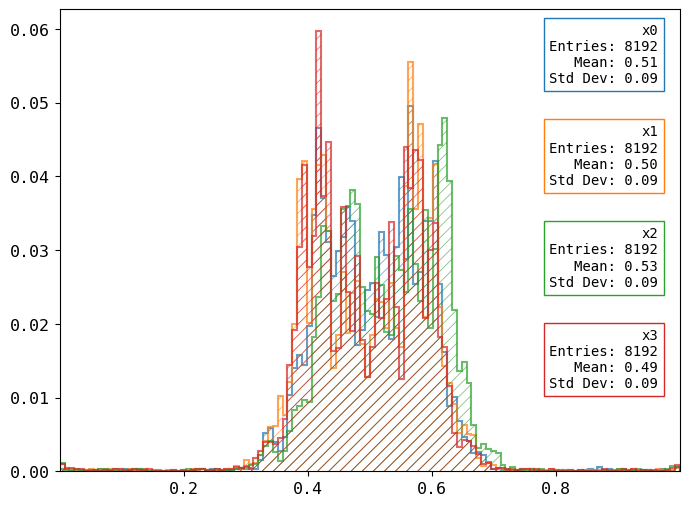

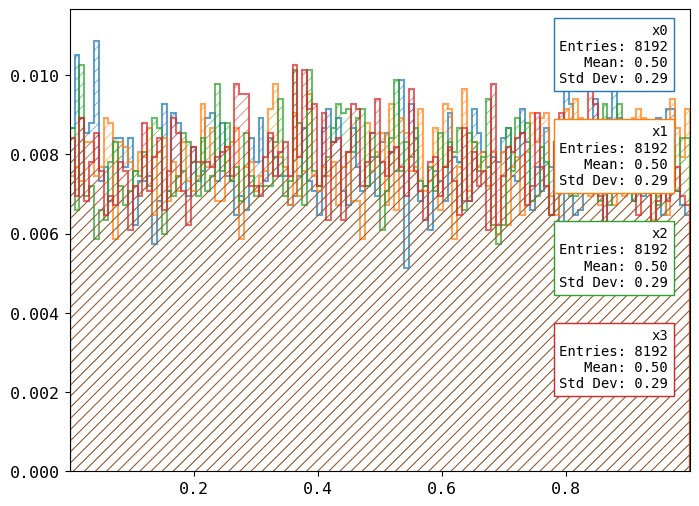

In [40]:
#nfm = get_nfm(q0=a, hidden_units=32, hidden_layers=5, num_bins=16, input_size=8, tails='linear', tail_bound=B)
#context = {}

plot_proposal(nis.nfm, n_samples=8192)
plot_proposal(nis.q0, n_samples=8192)

print(f'NF          : {get_result(nis.nfm, camel, n_samples=32000)}')
print(f'Uniform dist: {get_result(uniform, camel, n_samples=32000)}')

# samples, log_p = nfm.sample(1000)
# results = func(samples).detach().cpu().numpy()

# plot_integrand(nfm, func, n_samples=4096)

In [ ]:
def train_iflow(nfm, func:Callable, loss_func:Callable=kl_div,
                n_samples:int=64000, n_epochs:int=10, lr:float=5e-4,
                lr_decay_factor:float=0.9, context=context):
    
    if not 'optimizer' in context:
        context['optimizer'] = torch.optim.Adam(nfm.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_factor, last_epoch=-1)
    
    for i in range(n_epochs):
        context['optimizer'].zero_grad()
        
        samples, logq = nfm.sample(n_samples)
        true = torch.abs(func(samples)).detach()
        
        #with torch.no_grad():
        test = logq.exp()
        mean, var = torch.mean(true/test).detach(), torch.var(true/test).detach()
        
        true = true/mean
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16)            
        
        loss = loss_func(true, test, logp, logq)
        
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            context['optimizer'].step()
            #scheduler.step()
        else:
            print('Skipping loss')
        #loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        #loss = (1/n_samples) * var
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}") #| Last LR {scheduler.get_last_lr()}")

In [39]:
n_samples = 16000
#train_backward(nfm, func, n_epochs=20, n_samples=n_samples, lr=2e-4)
train_iflow(nfm, func, loss_func=exp_div, n_epochs=10, n_samples=n_samples, lr=1e-3, context=context)

Epoch 0: 6.2647576332092285 | Var 666.7169799804688
Epoch 1: 5.0625505447387695 | Var 13.407058715820312
Epoch 2: 5.059944152832031 | Var 2.349846601486206
Epoch 3: 5.957945823669434 | Var 2.4620614051818848
Epoch 4: 6.130379676818848 | Var 0.2831965684890747
Epoch 5: 7.112651348114014 | Var 0.1453842669725418
Epoch 6: 8.063054084777832 | Var 0.09338533878326416
Epoch 7: 9.13075065612793 | Var 0.053454454988241196
Epoch 8: 6.188966751098633 | Var 3.6143096622254234e-06
Epoch 9: 8.07107925415039 | Var 6.264872354222462e-05


NF          : (5.799052814836614e-05, 8.44038549985271e-06)
Uniform dist: (0.9110177755355835, 97.79975128173828)
Using inferred bounds 8.821487426757812e-06 to 0.9999701380729675


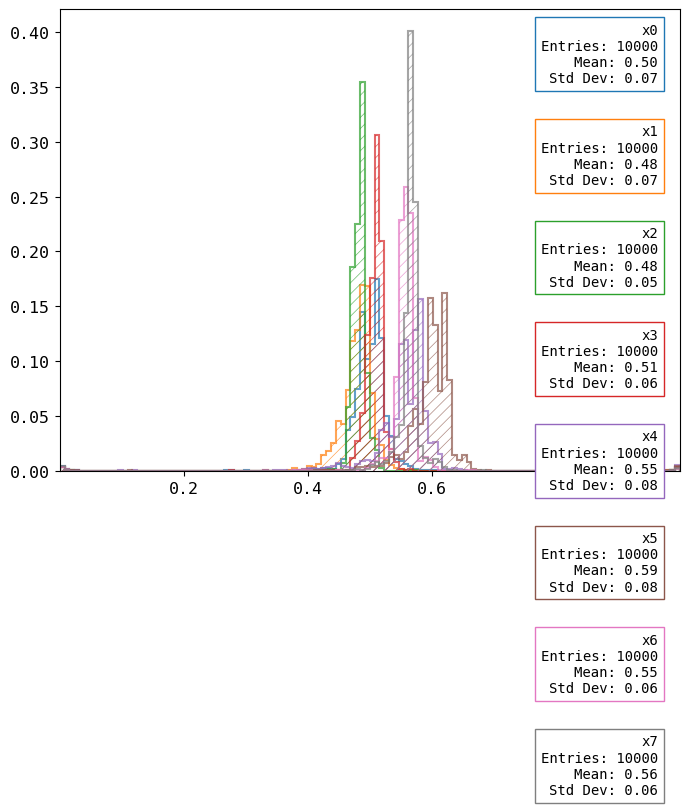

In [40]:
n_samples = 10000

print(f'NF          : {get_result(nfm, func, n_samples=n_samples)}')
print(f'Uniform dist: {get_result(a, func, n_samples=n_samples)}')

plot_proposal(nfm, n_samples=n_samples)

Using inferred bounds 1.0967254638671875e-05 to 0.9999980926513672


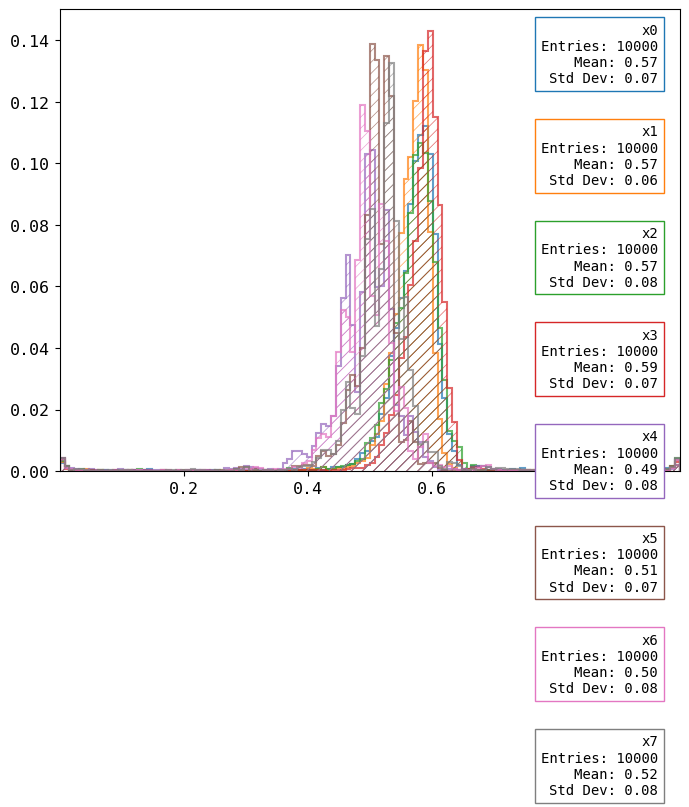

In [20]:
n_samples = 10000
plot_proposal(nfm, n_samples=n_samples)

In [242]:
print(f'NF @ Identity : {get_result(nfm, func, n_samples=32000)}')
print(f'Uniform dist  : {get_result(a, func, n_samples=32000)}')

NF @ Identity : (2.380526140311608e-26, 0.0)
Uniform dist  : (0.9595483541488647, 145.56045532226562)


In [97]:
def normalized(func, dist, n_samples:int=32000):
    integral, var = get_result(dist, func, n_samples=n_samples)
    return lambda args: func(args)/integral

(8.045150725074194, 2.422713075643302e-07)


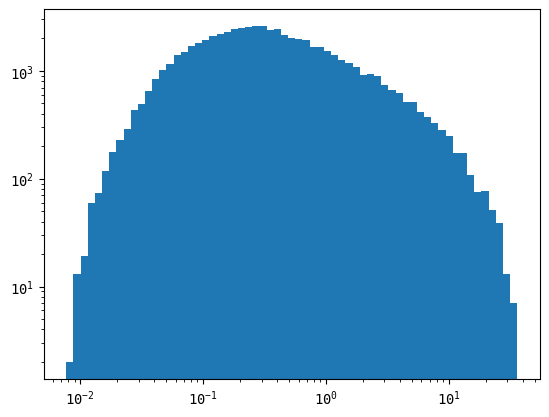

In [98]:
import scipy.integrate as integrate
func_n = normalized(func, a, 64000)

res = func_n(a.sample(64000))
#r = (samples.T[0]**2 + samples.T[1]**2 + samples.T[2]**2 ).sqrt()

logbins = np.geomspace(res.min(), res.max(), 64)
plt.hist(res, bins=logbins)
plt.xscale('log')
plt.yscale('log')

print(integrate.tplquad(lambda x,y,z: func_n(np.array([x,y,z])), -1, 1, -1, 1, -1, 1))

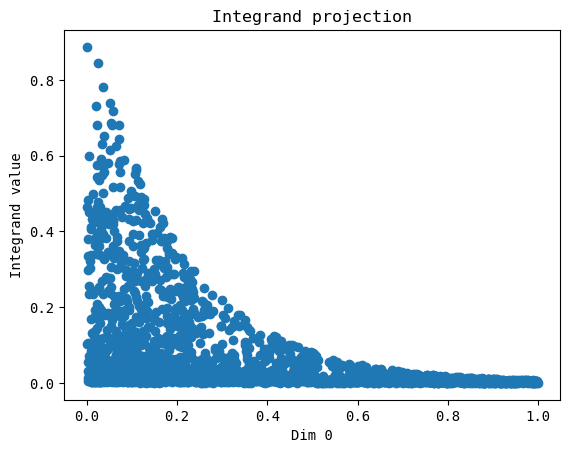

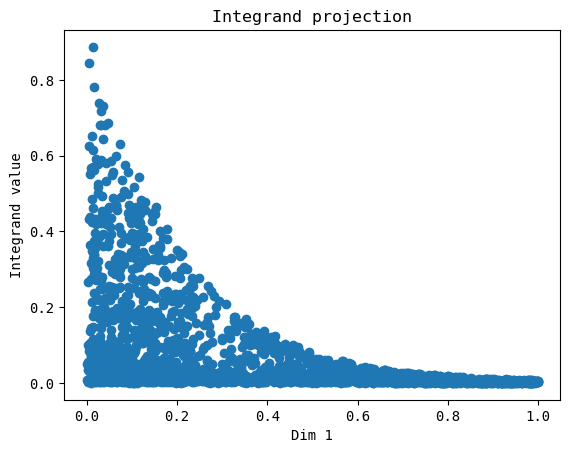

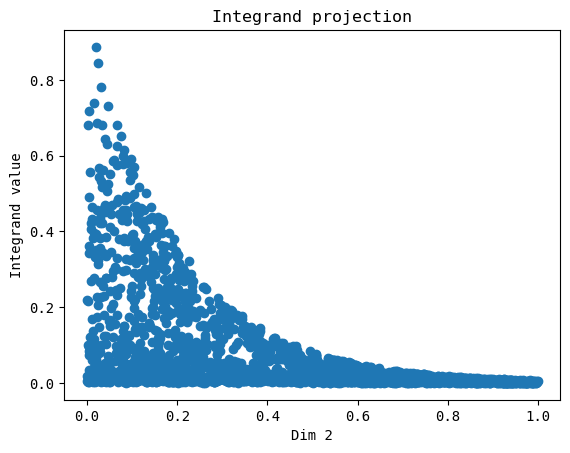

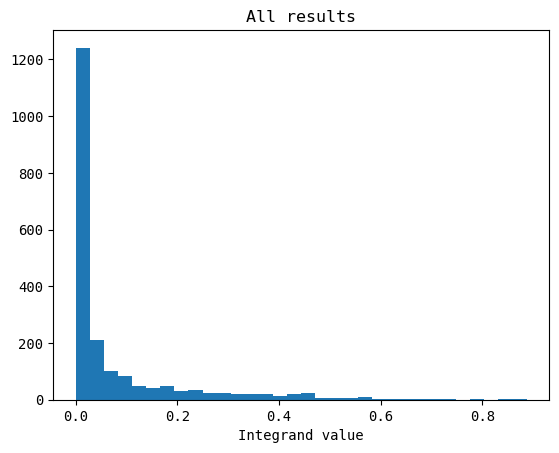

In [99]:
plot_integrand(nfm, func, y_log=False)

In [100]:
n_samples=4096
get_result(nfm, func, n_samples=n_samples)

(0.18802474439144135, 0.0030744464602321386)

In [101]:
with torch.no_grad():
    samples, logq = nfm.sample(n_samples)
    true = torch.abs(func(samples))
    test = logq.exp()
    mean = torch.mean(true/test).item()
    var = torch.var(true/test)

    print(mean, torch.sqrt(var/(n_samples-1.)).item())

0.18323089182376862 0.003156024729833007
